# Setup

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

from deap import algorithms, base, creator, tools

from sympy import *

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [33]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [60]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [61]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [62]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

input_range = {
    'cActivator': [0,10],
    # 'cInhibitor': [0,10], # Calculate cInhibitor values based on cActivator range
}

In [67]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor'

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 11, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values['cActivator'] = pair[0]
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor) but it may change
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [71]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.0, -0.6215098252031866), (1.0, 9.141322501..."
control__wt_glc__2,2.369230,"[(0.0, -0.6618609214775106), (1.0, 7.953538493..."
fur__wt_dpd__1,0.490542,"[(0.0, 1.1894055061723103), (1.0, 62.447836310..."
fur__wt_dpd__2,0.492320,"[(0.0, 1.180971427188386), (1.0, 62.1995688511..."
fur__wt_fe__1,1.756930,"[(0.0, -0.49339972486388645), (1.0, 12.9124004..."


# DEAP

In [72]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0,)) # Set to maximize dot product

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()

/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [107]:
random.seed(42)

def generate_individual(individual_class: type, data: pd.DataFrame):
    individual = individual_class(random.sample(grid,1)[0] for grid in grid['grid'])
    
    return individual

In [108]:
toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 data = grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

In [109]:
test_population = toolbox.population(n=3)

In [110]:
# Evaluate
MA_df = data.iloc[:,0:2]

def objective(individual: object, MA_df: pd.DataFrame):
    dot_product = []
    for i, _ in enumerate(MA_df.index):
        dot_product.append((np.dot([MA_df.iloc[i,0],MA_df.iloc[i,1]],individual[i]))**2)
    sum_dots = np.sum(dot_product)
    
    return sum_dots,

toolbox.register(alias = 'evaluate', function = objective, MA_df = MA_df)

In [111]:
toolbox.evaluate(test_population[0])

(30550936.75161817,)

In [112]:
# NOTE: Not sure what appropriate tournament size should be
toolbox.register("select", tools.selTournament, tournsize=5)

# NOTE: Using np.ndarray individuals requires a different method to compare individuals
hof = tools.HallOfFame(3, similar=np.array_equal)

In [113]:
# Mutation
def mutate(individual: object, prob: float, data: pd.DataFrame):
    for i, _ in enumerate(individual):
        if random.random() < prob:
            individual[i] = random.sample(grid.iloc[i,1],1)[0]

    return individual,

toolbox.register('mutate', function = mutate, prob = 1, data = data)

In [114]:
# Crossover
toolbox.register('mate', tools.cxESBlend, alpha=0.1)

In [115]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [116]:
MU = 10
LAMBDA = 20
pop = toolbox.population(n=30)

pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=MU, lambda_=LAMBDA, 
            cxpb=0, mutpb=0.3, ngen=10, stats=stats, halloffame=hof, verbose=False)

In [117]:
logbook

[{'gen': 0,
  'nevals': 30,
  'avg': 24095087.283019885,
  'std': 4322459.287839453,
  'min': 17772224.74278598,
  'max': 32930578.50665649},
 {'gen': 1,
  'nevals': 2,
  'avg': 29741765.798047226,
  'std': 942396.2842946164,
  'min': 27234152.0550085,
  'max': 30669200.449283283},
 {'gen': 2,
  'nevals': 4,
  'avg': 30085270.63747471,
  'std': 476776.69484347134,
  'min': 29695984.096268993,
  'max': 30669200.449283283},
 {'gen': 3,
  'nevals': 6,
  'avg': 30279913.908077568,
  'std': 476776.69484347134,
  'min': 29695984.096268993,
  'max': 30669200.449283283},
 {'gen': 4,
  'nevals': 8,
  'avg': 30571878.813981853,
  'std': 291964.9059042871,
  'min': 29695984.096268993,
  'max': 30669200.449283283},
 {'gen': 5,
  'nevals': 7,
  'avg': 30669200.449283283,
  'std': 0.0,
  'min': 30669200.449283283,
  'max': 30669200.449283283},
 {'gen': 6,
  'nevals': 4,
  'avg': 31093195.44511848,
  'std': 1271984.9875055852,
  'min': 30669200.449283283,
  'max': 34909150.407635234},
 {'gen': 7,
  '

In [118]:
toolbox.evaluate(hof[0])

(36529352.08272176,)

In [119]:
hof[0]

individual([[ 9.00000000e+00,  8.72439811e+01],
            [ 2.00000000e+00,  1.65689379e+01],
            [ 7.00000000e+00,  4.29998421e+02],
            [ 0.00000000e+00,  1.18097143e+00],
            [ 4.00000000e+00,  5.31298009e+01],
            [ 1.00000000e+00,  1.23204959e+01],
            [ 7.00000000e+00,  3.86583729e+02],
            [ 4.00000000e+00,  1.96434506e+02],
            [ 4.00000000e+00,  5.43893715e+01],
            [ 5.00000000e+00,  7.58711728e+01],
            [ 2.00000000e+00,  3.61377697e+01],
            [ 7.00000000e+00,  1.30958646e+02],
            [ 7.00000000e+00,  1.37478466e+02],
            [ 7.00000000e+00,  1.22223065e+02],
            [ 2.00000000e+00,  3.87837325e+01],
            [ 9.00000000e+00,  1.67533438e+02],
            [ 5.00000000e+00,  9.42142234e+01],
            [ 6.00000000e+00,  1.10757231e+02],
            [ 9.00000000e+00,  3.11591835e+02],
            [ 2.00000000e+00,  6.37379070e+01],
            [ 8.00000000e+00,  2.2306414

In [120]:
MA_df

,MA_activator,MA_inhibitor
control__wt_glc__1,0.019182,0.028499
control__wt_glc__2,-0.019182,-0.028499
fur__wt_dpd__1,-0.963901,-0.473642
fur__wt_dpd__2,-1.116929,-0.541595
fur__wt_fe__1,0.043720,-0.054857
...,...,...
efeU__menFentCubiC_ale36__2,-0.194079,-0.128973
efeU__menFentCubiC_ale37__1,-0.178657,-0.057887
efeU__menFentCubiC_ale37__2,-0.161924,-0.092028
efeU__menFentCubiC_ale38__1,0.045234,-0.313445


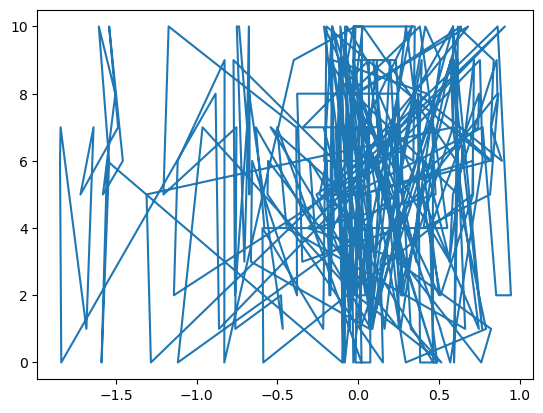

In [122]:
plt.plot(MA_df.iloc[:,0], hof[0][:,0])

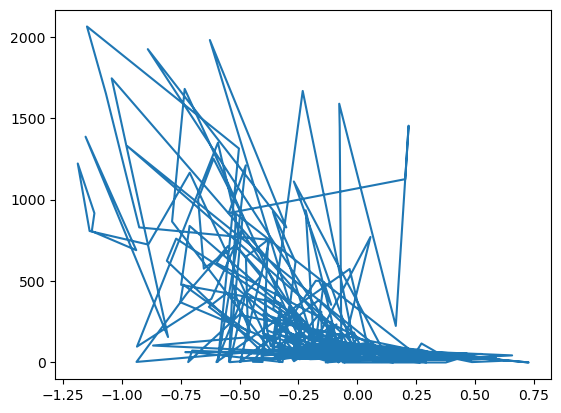

In [123]:
plt.plot(MA_df.iloc[:,1], hof[0][:,1])